In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from fbprophet import Prophet

In [2]:
df_sales = pd.read_csv('sales_train_v2.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'],  dayfirst=True)

In [3]:
df_sales_fbprophet = df_sales.loc[(df_sales['item_cnt_day']>0)&
                                #(df_sales['date']>pd.to_datetime('2014-10-01'))&
                                (df_sales['item_id']==20949)]
                                
df_sales_fbprophet = df_sales_fbprophet.groupby(['date'])['item_cnt_day'].sum().reset_index(name='item_cnt_day_total')
df_sales_fbprophet


,date,item_cnt_day_total
0,2013-04-24,8.0
1,2013-04-25,25.0
2,2013-04-26,43.0
3,2013-04-27,38.0
4,2013-04-28,38.0
...,...,...
916,2015-10-27,74.0
917,2015-10-28,90.0
918,2015-10-29,92.0
919,2015-10-30,118.0


In [4]:
df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date": "ds", "item_cnt_day_total": "y"})
df_sales_fbprophet['floor']=0
df_sales_fbprophet['cap']=df_sales_fbprophet['y'].max()
df_sales_fbprophet

,ds,y,floor,cap
0,2013-04-24,8.0,0,1137.0
1,2013-04-25,25.0,0,1137.0
2,2013-04-26,43.0,0,1137.0
3,2013-04-27,38.0,0,1137.0
4,2013-04-28,38.0,0,1137.0
...,...,...,...,...
916,2015-10-27,74.0,0,1137.0
917,2015-10-28,90.0,0,1137.0
918,2015-10-29,92.0,0,1137.0
919,2015-10-30,118.0,0,1137.0


In [5]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True, 
            seasonality_mode='multiplicative', growth='logistic')
m.fit(df_sales_fbprophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [6]:
# find how many periods we need by finding the last day in the item
days_to_predict = pd.to_datetime('2016-1-31') - df_sales_fbprophet['ds'].max()
days_to_predict.days

92

In [7]:
# predict a few days into the future so we have a full month in November
future = m.make_future_dataframe(periods=days_to_predict.days)
future['floor']=0
future['cap']=df_sales_fbprophet['y'].max()

future.tail()

,ds,floor,cap
1008,2016-01-27,0,1137.0
1009,2016-01-28,0,1137.0
1010,2016-01-29,0,1137.0
1011,2016-01-30,0,1137.0
1012,2016-01-31,0,1137.0


In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1008,2016-01-27,53.990700,-52.484773,163.701751
1009,2016-01-28,61.350195,-45.916936,175.303675
1010,2016-01-29,84.348550,-17.258602,196.406547
1011,2016-01-30,127.839577,23.831745,235.310183
1012,2016-01-31,98.282736,-8.541544,208.646393


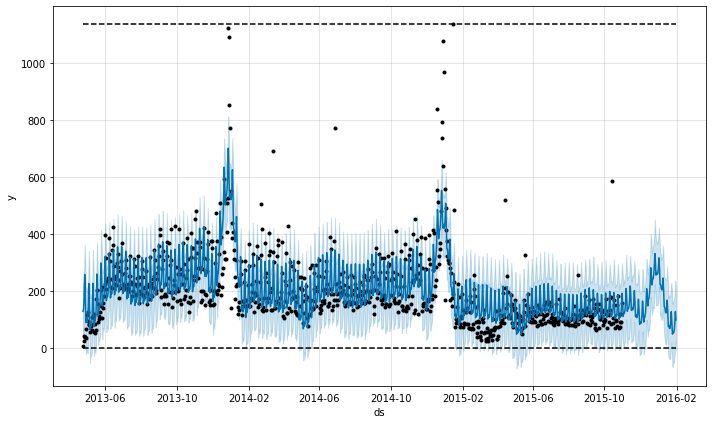

In [9]:
fig1 = m.plot(forecast)

In [10]:
# 30 days of November
forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat']

921    158.161318
922    111.117902
923    124.352240
924    122.112251
925    132.087754
926    159.142892
927    208.785224
928    175.618300
929    128.969511
930    141.495014
931    138.176861
932    146.435245
933    171.104960
934    217.673437
935    181.832698
936    132.290899
937    141.064892
938    133.965187
939    138.239934
940    158.781845
941    201.134493
942    162.131679
943    109.914921
944    115.897278
945    106.721928
946    109.458386
947    129.028868
948    170.985026
949    133.225975
950     83.247167
Name: yhat, dtype: float64

In [11]:
# forecast for the whole month of November
forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat'].sum()

4343.154084101207